# 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import KNN
from esda.moran import Moran
import logging
import matplotlib.pyplot as plt
from shapely import is_valid, make_valid
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from mgwr.gwr import MGWR
from scipy.spatial.distance import cdist
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy.linalg

In [2]:
# Load parks data
parks_lst_gdf = gpd.read_file('Data/Riyadh_parks_with_LST.geojson')
print("Loaded parks_gdf with columns:", parks_lst_gdf.columns)

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'Park_id', 'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean',
       'ndvi_pixel_count', 'pisi_mean', 'pisi_pixel_count', 'building_density',
       'building_proximity', 'lst_buffer_30m', 'lst_buffer_60m',
       'lst_buffer_90m', 'lst_buffer_120m', 'lst_buffer_150m',
       'lst_buffer_180m', 'lst_buffer_210m', 'lst_buffer_240m',
       'lst_buffer_270m', 'lst_buffer_300m', 'lst_park', 'park_pixel_count',
       'lst_surrounding_mean', 'lst_reduction', 'lst_data', 'cubic_coeffs',
       'r_squared', 'PCD', 'PCI', 'PCA', 'PCE', 'PCD_source', 'geometry'],
      dtype='object')


## 1.1 Checking Parks Selection Criteria
- Remove parks within 300m to avoid overlapping cooling effects (aligned with max buffer radius).

In [3]:
# Create a new DataFrame to avoid modifying the original
filtered_parks_gdf = parks_lst_gdf.copy()

In [4]:
# Extract centroids for distance calculation
centroids = filtered_parks_gdf.copy()
centroids['geometry'] = centroids.geometry.centroid

# Initialize a set to track parks to remove (both from each close pair)
parks_to_remove = set()

# Calculate pairwise distances and identify close pairs (<300m)
for i, park1 in centroids.iterrows():
    for j, park2 in centroids.iterrows():
        if i < j:  # Avoid duplicate pairs and self-comparison
            dist = park1.geometry.distance(park2.geometry)
            if dist < 300:  # 300m threshold based on max buffer radius
                parks_to_remove.add(park1['Park_id'])
                parks_to_remove.add(park2['Park_id'])

# Remove both parks from each close pair
filtered_parks_gdf = filtered_parks_gdf[~filtered_parks_gdf['Park_id'].isin(parks_to_remove)]

# Summary of changes
num_removed = len(parks_lst_gdf) - len(filtered_parks_gdf)
print(f"Number of parks removed: {num_removed}")
print(f"Original number of parks: {len(parks_lst_gdf)}")
print(f"New number of parks: {len(filtered_parks_gdf)}")
print(f"Removed Park IDs: {sorted(list(parks_to_remove))}")


Number of parks removed: 25
Original number of parks: 219
New number of parks: 194
Removed Park IDs: [21.0, 26.0, 38.0, 41.0, 50.0, 63.0, 64.0, 65.0, 69.0, 75.0, 77.0, 79.0, 80.0, 83.0, 84.0, 87.0, 88.0, 89.0, 114.0, 137.0, 140.0, 154.0, 169.0, 170.0, 182.0]


In [5]:
data_gdf = filtered_parks_gdf.copy()
print(f"Rows after filtering : {len(data_gdf)}")
# Create working copy of filtered data for analysis.

Rows after filtering : 194


In [6]:
# Ensure valid geometries
invalid_count = (~data_gdf.geometry.is_valid).sum()
if invalid_count > 0:
    print(f"Warning: {invalid_count} invalid geometries detected, repairing.")
    invalid_ids = data_gdf[~data_gdf.geometry.is_valid]['Park_id'].tolist()
    print(f"Invalid Park IDs: {invalid_ids}")
    data_gdf['geometry'] = data_gdf['geometry'].apply(lambda geom: make_valid(geom) if not is_valid(geom) else geom)

Invalid Park IDs: [155.0]


In [7]:
# Transform area to reduce skewness, common for size variables in geospatial studies.
data_gdf['log_area_m2'] = np.log(data_gdf['area_m2'] + 1) #Adding 1 before prevents errors with zero or negative values

In [8]:
data_gdf['area_m2'].skew()

np.float64(4.993409937183961)

In [9]:
data_gdf['log_area_m2'].skew()

np.float64(1.21196717045811)

## 1.2 Standardization Check

**Standardization Strategy**: Predictors standardized due to mixed scales (e.g., log_area_m2 vs. NDVI). Dependent variables (PCI, PCA, PCE) kept in raw units (°C, m²) for interpretability in synthesis (Obj 3). Exploratory run with standardized Y post-PCI analysis to compare effect sizes across metrics (Obj 2).

In [10]:
# Define predictors and cooling metrics
predictors = ['log_area_m2', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity']
cooling_metrics = ['PCI', 'PCA', 'PCE', 'lst_reduction']

# Check scales for predictors and dependent variables
print("Predictor Scales:\\n", data_gdf[predictors].describe())
print("\\nCooling Metrics Scales:\\n", data_gdf[cooling_metrics].describe())

# Toggle for standardization
standardize = False  # Standardize predictors due to mixed scales
standardize_y = False  #  Change to True for explatory run

# Initialize scaler (fit deferred to another cell)
scaler = StandardScaler() if standardize else None
scaler_y_dict = {}
if standardize_y:
    for metric in cooling_metrics:
        scaler_y_dict[metric] = StandardScaler()

# Extract coordinates from working data
data_gdf['centroid'] = data_gdf.geometry.centroid
coords = np.array(list(zip(data_gdf.centroid.x, data_gdf.centroid.y)))

# Create spatial weights using KNN (k=4)
w = KNN.from_dataframe(data_gdf, k=4)
w.transform = 'r'

Predictor Scales:\n        log_area_m2   ndvi_mean   pisi_mean         LSI  building_density  \
count   194.000000  194.000000  194.000000  194.000000        194.000000   
mean      8.737517    0.149629   -0.173575    1.218093         32.540256   
std       1.091700    0.035262    0.069084    0.180563          7.907630   
min       6.895126    0.056360   -0.376677    1.060000          1.359572   
25%       7.982114    0.126020   -0.220448    1.130000         28.403743   
50%       8.534237    0.147426   -0.177248    1.170000         33.158802   
75%       9.209997    0.172987   -0.127368    1.230000         37.660383   
max      12.461221    0.235770    0.045596    2.900000         52.980830   

       building_proximity  
count          194.000000  
mean            17.870162  
std             11.958802  
min              1.620812  
25%             11.352582  
50%             15.768115  
75%             20.725466  
max             96.376621  
\nCooling Metrics Scales:\n               P

## 2. Analysis

### 2.1 Define Reusable Functions

In [11]:
# Set up logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [12]:
def run_ols_regression(data_gdf, metric, predictors, w, scaler, standardize, standardize_y, scaler_y=None):
    if standardize:
        if scaler is None or not hasattr(scaler, 'scale_'):  # Check if scaler is fitted
            scaler = StandardScaler().fit(data_gdf[predictors])  # Fit if not fitted
        X = scaler.transform(data_gdf[predictors])
    else:
        X = data_gdf[predictors].values
    y_raw = data_gdf[metric].values  # Keep raw y for potential later use
    y = y_raw.copy()  # Work on a copy
    if standardize_y and scaler_y is not None:
        if not hasattr(scaler_y, 'scale_'):  # Auto-fit if not fitted
            scaler_y.fit(y.reshape(-1, 1))
        y = scaler_y.transform(y.reshape(-1, 1)).flatten()
    X_ols = sm.add_constant(X)  # Add constant term
    model = sm.OLS(y, X_ols).fit()  # Fit OLS model
    moran = Moran(model.resid, w)  # Compute Moran's I for residuals
    return {
        'model': model,  # Store fitted model
        'summary': model.summary(),  # Store summary statistics
        'moran_i': moran.I,  # Store Moran's I
        'moran_p': moran.p_norm,  # Store p-value
        'rss': model.ssr # For Validation
    }

In [13]:
def run_mgwr_regression(data_gdf, metric, predictors, coords, w, n_samples, scaler, standardize, standardize_y, scaler_y=None):
    if standardize:
        if scaler is None or not hasattr(scaler, 'scale_'):  # Check if scaler is fitted
            scaler = StandardScaler().fit(data_gdf[predictors])  # Fit if not fitted
        X = scaler.transform(data_gdf[predictors])
    else:
        X = data_gdf[predictors].values
    y_raw = data_gdf[metric].values.reshape(-1, 1)  # Keep raw y for potential later use
    y = y_raw.copy()  # Work on a copy
    if standardize_y and scaler_y is not None:
        if not hasattr(scaler_y, 'scale_'):  # Auto-fit if not fitted
            scaler_y.fit(y)
        y = scaler_y.transform(y)
    
    selector = Sel_BW(coords, y, X, multi=True, kernel='bisquare', fixed=False)  # Initialize bandwidth selector
    bw = selector.search(criterion='AICc')  # Your chosen criterion
    if bw is None or any(b > n_samples - 1 for b in bw):  # Check for invalid bandwidths
        logger.warning(f"Invalid bandwidths for {metric}. Falling back to half sample size.")
        bw = np.full(len(predictors) + 1, max(2, n_samples // 2), dtype=int)  # Use fallback bandwidth
    mgwr_model = MGWR(coords, y, X, selector, fixed=False, kernel='bisquare')  # Initialize MGWR model
    mgwr_results_metric = mgwr_model.fit()  # Fit MGWR model
    rss_manual = np.sum(mgwr_results_metric.resid_response ** 2)  # Manual RSS since it's not yet supported by mgwr
    return {
        'model': mgwr_results_metric, 
        'bandwidths': bw,
        'rss': rss_manual
        }

In [14]:
def store_mgwr_results(data_gdf, metric, mgwr_results, predictor_names, standardize_y, scaler_y=None):
    mgwr_results_metric = mgwr_results['model']
    for i, pred in enumerate(predictor_names): # Iterate over predictors
        data_gdf[f'{metric}_coef_{pred}'] = mgwr_results_metric.params[:, i]
        data_gdf[f'{metric}_tval_{pred}'] = mgwr_results_metric.filter_tvals()[:, i]
        data_gdf[f'{metric}_sig_{pred}'] = np.abs(data_gdf[f'{metric}_tval_{pred}']) > 1.96
    y_pred = mgwr_results_metric.predy.flatten()
    if standardize_y and scaler_y is not None:
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = data_gdf[metric].values
    local_r2_proxy = np.corrcoef(y_true, y_pred)[0, 1] ** 2 # Compute local R² proxy
    data_gdf[f'{metric}_localR2_proxy'] = local_r2_proxy

### 2.2 Model Diagnostics
Check multicollinearity via VIF (threshold >5 suggests issues) to ensure reliable coefficients. 

Note: High correlation (-0.79) between `pisi_mean` and `ndvi_mean` observed; `pisi_mean` retained for its imperviousness effect, with local significance monitored.

VIF Results:
               feature       VIF
0         log_area_m2  1.657537
1           ndvi_mean  2.869838
2           pisi_mean  2.816772
3                 LSI  1.184877
4    building_density  1.320755
5  building_proximity  1.706075


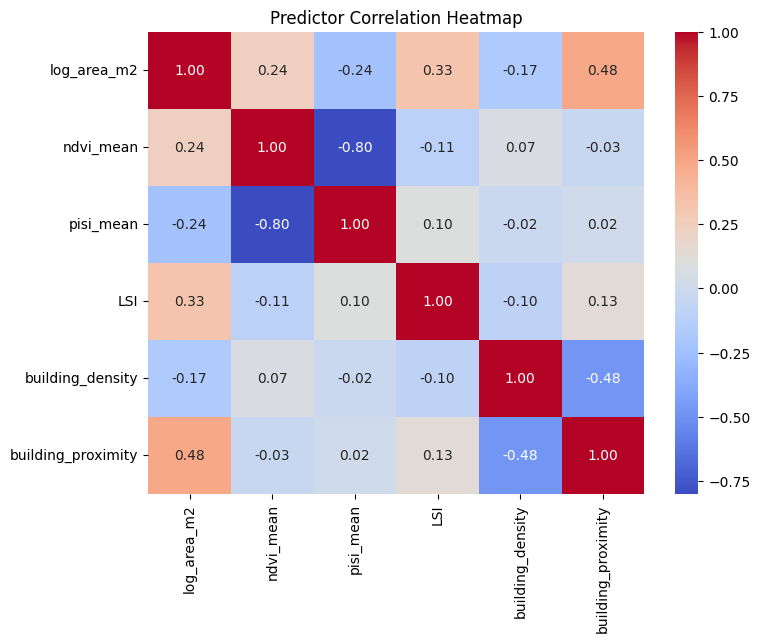

In [15]:
# Compute VIF for predictors
X_vif = sm.add_constant(data_gdf[predictors])
vif_data = pd.DataFrame()
vif_data['feature'] = predictors
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(predictors))]
print("VIF Results:\n", vif_data)

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data_gdf[predictors].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Predictor Correlation Heatmap')
plt.show()
# Logic: High VIF (>5) or correlations (>0.7) may bias coefficients; informs interaction terms.

In [16]:
# Use original predictors
predictors = ['log_area_m2', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity']

# Refit scaler with updated predictors
if standardize:
    scaler.fit(data_gdf[predictors])
    X = scaler.transform(data_gdf[predictors])
else:
    X = data_gdf[predictors].values

# Update predictor names including constant
predictor_names = ['const'] + predictors

# Redefine spatial weights for consistency
w = KNN.from_dataframe(data_gdf, k=4)
w.transform = 'r'

### 2.3 Model Runs


Perform OLS and MGWR to quantify relationships with predictors, including interactions. Uses Bi-square kernel, AICc for bandwidth optimization, per [Huand et al., 2025](https://www.nature.com/articles/s41598-025-07904-8)

#### 2.3.1 PCI

In [17]:
# Run OLS regression for PCI
ols_pci = run_ols_regression(data_gdf, 'PCI', predictors, w, scaler, standardize, standardize_y, scaler_y_dict.get('PCI'))
print(f"\nOLS Summary for PCI:\n{ols_pci['summary']}")
print(f"Moran's I for residuals: {ols_pci['moran_i']:.4f}, p-value: {ols_pci['moran_p']:.4f}")
print(f"OLS AIC: {ols_pci['model'].aic:.4f}")
# Logic: OLS as baseline; Moran's I tests spatial autocorrelation.


OLS Summary for PCI:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     15.38
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           2.63e-14
Time:                        17:25:44   Log-Likelihood:                -230.00
No. Observations:                 194   AIC:                             474.0
Df Residuals:                     187   BIC:                             496.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1167      0.6

In [18]:
# Run MGWR regression for PCI
mgwr_pci = run_mgwr_regression(data_gdf, 'PCI', predictors, coords, w, len(data_gdf), scaler, standardize, standardize_y, scaler_y_dict.get('PCI'))
print(f"MGWR Optimal Bandwidths for PCI: {mgwr_pci['bandwidths']}")
print(f"MGWR Summary for PCI:")
print(f"Global R2: {mgwr_pci['model'].R2:.4f}")
print(f"MGWR AIC: {mgwr_pci['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

MGWR Optimal Bandwidths for PCI: [193. 193.  50. 193. 193. 193. 186.]
MGWR Summary for PCI:
Global R2: 0.4160
MGWR AIC: 468.9957


In [19]:
# Store MGWR results for PCI
store_mgwr_results(data_gdf, 'PCI', mgwr_pci, predictor_names, standardize_y, scaler_y_dict.get('PCI'))
print(f"Local R2 Proxy: {data_gdf['PCI_localR2_proxy'].mean():.4f}")
# Logic: Store coefficients and significance; local R² proxy evaluates fit.

Local R2 Proxy: 0.4179


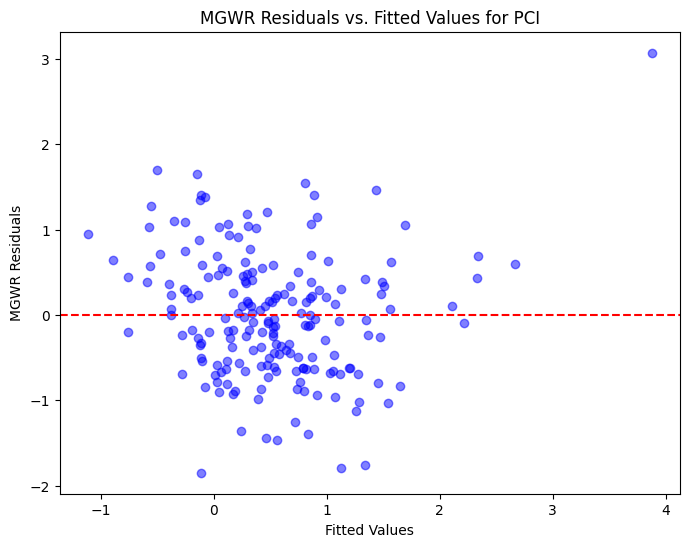

In [20]:
# MGWR residuals vs. fitted values
mgwr_residuals = data_gdf['PCI'] - mgwr_pci['model'].predy.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(mgwr_pci['model'].predy.flatten(), mgwr_residuals, c='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('MGWR Residuals')
plt.title('MGWR Residuals vs. Fitted Values for PCI')
plt.show()



Assessment: 
- Linearity: No curved pattern.
- Homoscedasticity: Constant variance.
- Independence: Random scatter, no clustering.
- Outliers: Minimal, unlikely to bias results.

#### 2.3.2 PCA

In [21]:
# Run OLS and MGWR for PCA
ols_pca = run_ols_regression(data_gdf, 'PCA', predictors, w, scaler, standardize, standardize_y, scaler_y_dict.get('PCA'))
print(f"\nOLS Summary for PCA:\n{ols_pca['summary']}")
print(f"Moran's I for residuals: {ols_pca['moran_i']:.4f}, p-value: {ols_pca['moran_p']:.4f}")
print(f"OLS AIC: {ols_pca['model'].aic:.4f}")


OLS Summary for PCA:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     26.91
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           5.30e-23
Time:                        17:28:44   Log-Likelihood:                -2124.5
No. Observations:                 194   AIC:                             4263.
Df Residuals:                     187   BIC:                             4286.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.972e+04   1.14e+

In [22]:
mgwr_pca = run_mgwr_regression(data_gdf, 'PCA', predictors, coords, w, len(data_gdf), scaler, standardize, standardize_y, scaler_y_dict.get('PCA'))
print(f"\nMGWR Optimal Bandwidths for PCA: {mgwr_pca['bandwidths']}")
print(f"MGWR Summary for PCA:")
print(f"Global R2: {mgwr_pca['model'].R2:.4f}")
print(f"MGWR AIC: {mgwr_pca['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


MGWR Optimal Bandwidths for PCA: [193. 193. 193. 193. 193. 193. 129.]
MGWR Summary for PCA:
Global R2: 0.4817
MGWR AIC: 4265.3447


In [23]:

store_mgwr_results(data_gdf, 'PCA', mgwr_pca, predictor_names, standardize_y, scaler_y_dict.get('PCA'))
print(f"Local R2 Proxy: {data_gdf['PCA_localR2_proxy'].mean():.4f}")


Local R2 Proxy: 0.4818


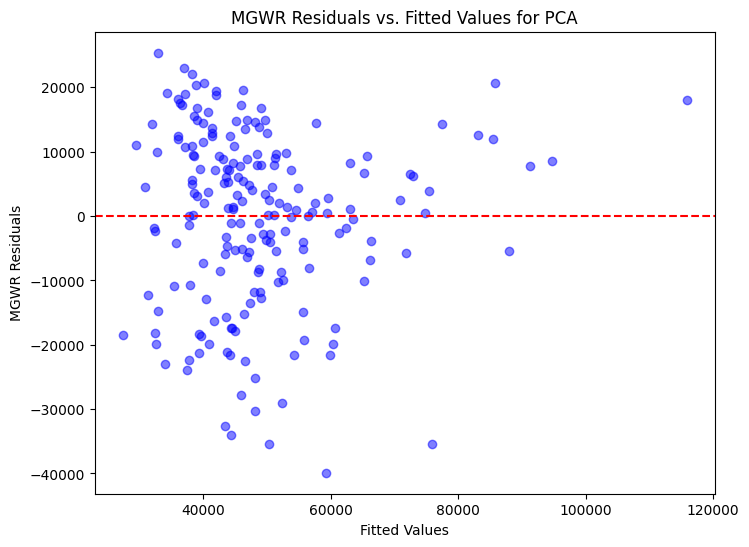

In [24]:
# PCA residuals
mgwr_residuals_pca = data_gdf['PCA'] - mgwr_pca['model'].predy.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(mgwr_pca['model'].predy.flatten(), mgwr_residuals_pca, c='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('MGWR Residuals')
plt.title('MGWR Residuals vs. Fitted Values for PCA')
plt.show()

Assessment: 
- Linearity: Random distribution.
- Homoscedasticity: Mild heteroscedasticity (spread increases slightly).
- Outliers: A few large residuals at high fitted values may indicate over-prediction for large parks.

#### 2.3.3 PCE

In [25]:
# Run OLS and MGWR for PCE
ols_pce = run_ols_regression(data_gdf, 'PCE', predictors, w, scaler, standardize, standardize_y, scaler_y_dict.get('PCE'))
print(f"\nOLS Summary for PCE:\n{ols_pce['summary']}")
print(f"Moran's I for residuals: {ols_pce['moran_i']:.4f}, p-value: {ols_pce['moran_p']:.4f}")
print(f"OLS AIC: {ols_pce['model'].aic:.4f}")


OLS Summary for PCE:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     43.61
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           4.54e-33
Time:                        17:30:18   Log-Likelihood:                -601.50
No. Observations:                 194   AIC:                             1217.
Df Residuals:                     187   BIC:                             1240.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4959      4.4

In [26]:
mgwr_pce = run_mgwr_regression(data_gdf, 'PCE', predictors, coords, w, len(data_gdf), scaler, standardize, standardize_y, scaler_y_dict.get('PCE'))
print(f"\nMGWR Optimal Bandwidths for PCE: {mgwr_pce['bandwidths']}")
print(f"MGWR Summary for PCE:")
print(f"Global R2: {mgwr_pce['model'].R2:.4f}")
print(f"MGWR AIC: {mgwr_pce['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


MGWR Optimal Bandwidths for PCE: [193. 193. 193. 193. 193. 193. 193.]
MGWR Summary for PCE:
Global R2: 0.5859
MGWR AIC: 1221.2717


In [27]:
store_mgwr_results(data_gdf, 'PCE', mgwr_pce, predictor_names, standardize_y, scaler_y_dict.get('PCE'))
print(f"Local R2 Proxy: {data_gdf['PCE_localR2_proxy'].mean():.4f}")

Local R2 Proxy: 0.5862


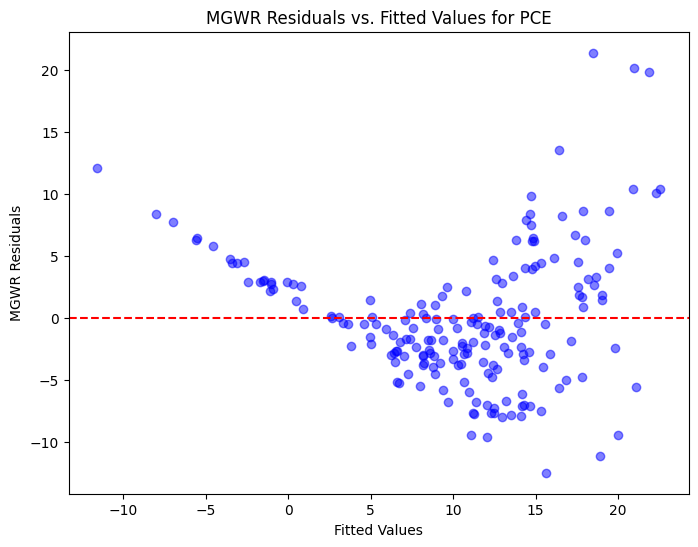

In [28]:
# PCE residuals
mgwr_residuals_pce = data_gdf['PCE'] - mgwr_pce['model'].predy.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(mgwr_pce['model'].predy.flatten(), mgwr_residuals_pce, c='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('MGWR Residuals')
plt.title('MGWR Residuals vs. Fitted Values for PCE')
plt.show()
# Logic: Ensure model assumptions hold for PCA and PCE.

Assessment: 
- Linearity: No pattern, indicating good fit.
- Homoscedasticity: Potential heteroscedasticity (increasing spread).
- Outliers: Several positive residuals at high fitted values, possibly skewing efficiency.

### 2.4 Internal Impact

Repeat analysis for lst_reduction to measure internal impact factors, using existing predictors and settings.

In [29]:
# Run OLS and MGWR for lst_reduction without interactions
ols_lst = run_ols_regression(data_gdf, 'lst_reduction', predictors, w, scaler, standardize, standardize_y, scaler_y_dict.get('lst_reduction'))
print("OLS Summary for lst_reduction:")
print(ols_lst['summary'])
print(f"Moran's I for residuals: {ols_lst['moran_i']:.4f}, p-value: {ols_lst['moran_p']:.4f}")
print(f"OLS AIC: {ols_lst['model'].aic:.4f}")

OLS Summary for lst_reduction:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     21.39
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           4.68e-19
Time:                        17:31:26   Log-Likelihood:                -182.74
No. Observations:                 194   AIC:                             379.5
Df Residuals:                     187   BIC:                             402.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0793

In [30]:
mgwr_lst = run_mgwr_regression(data_gdf, 'lst_reduction', predictors, coords, w, len(data_gdf), scaler, standardize, standardize_y, scaler_y_dict.get('lst_reduction'))
print(f"\nMGWR Optimal Bandwidths for lst_reduction: {mgwr_lst['bandwidths']}")
print(f"MGWR Summary for lst_reduction:")
print(f"Global R2: {mgwr_lst['model'].R2:.4f}")
print(f"MGWR AIC: {mgwr_lst['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Store MGWR results for lst_reduction
store_mgwr_results(data_gdf, 'lst_reduction', mgwr_lst, predictor_names, standardize_y, scaler_y_dict.get('lst_reduction'))
print(f"Local R2 Proxy: {data_gdf['lst_reduction_localR2_proxy'].mean():.4f}")

In [ ]:
# MGWR residuals vs. fitted values for lst_reduction
mgwr_residuals_lst = data_gdf['lst_reduction'] - mgwr_lst['model'].predy.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(mgwr_lst['model'].predy.flatten(), mgwr_residuals_lst, c='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('MGWR Residuals')
plt.title('MGWR Residuals vs. Fitted Values for lst_reduction')
plt.show()

Assessment: 
- Linearity: No pattern, indicating good fit.
- Homoscedasticity: Even spread, minimal variance change.
- Independence: Random scatter, no clustering.
- Outliers: Minor (one at ~2).

## 3. Data Export
Export results with coefficients and significance for QGIS visualization.

In [ ]:
# Drop centroid column to avoid multiple geometry columns
data_gdf = data_gdf.drop(columns=['centroid'])

# Export for visualization
data_gdf.to_file('Data/Riyadh_parks_with_all_variables_raw_nostandarization.geojson', driver='GeoJSON')
print("Exported data to 'Riyadh_parks_with_all_variables.geojson' for QGIS visualization.")


## 4. Cross Validation


Cross-validation (5-fold) was added to validate model generalizability.

In [71]:
## For Cross validation

def cross_validate_model(data_gdf, metric, predictors, coords, w, scaler, standardize, standardize_y, scaler_y=None, model_type='ols', n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=False)  # Non-shuffled for spatial-ish order
    mse_scores = []
    r2_scores = []
    
    for train_idx, test_idx in kf.split(data_gdf):
        train_gdf = data_gdf.iloc[train_idx]
        test_gdf = data_gdf.iloc[test_idx]
        
        # Extract train/test coords and weights (refit weights on train)
        train_coords = np.array(list(zip(train_gdf.centroid.x, train_gdf.centroid.y)))
        test_coords = np.array(list(zip(test_gdf.centroid.x, test_gdf.centroid.y)))
        train_w = KNN.from_dataframe(train_gdf, k=4)
        train_w.transform = 'r'
        
        # Prepare data
        X_train = scaler.transform(train_gdf[predictors]) if standardize else train_gdf[predictors].values
        X_test = scaler.transform(test_gdf[predictors]) if standardize else test_gdf[predictors].values
        y_train = train_gdf[metric].values.reshape(-1, 1)
        y_test = test_gdf[metric].values
        
        if standardize_y and scaler_y is not None:
            y_train = scaler_y.fit_transform(y_train)  # Fit scaler_y on train data only
            y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
        
        if model_type == 'ols':
            X_train_ols = sm.add_constant(X_train)
            model = sm.OLS(y_train.flatten(), X_train_ols).fit()
            X_test_ols = sm.add_constant(X_test)
            y_pred = model.predict(X_test_ols)
        elif model_type == 'mgwr':
            # Fit MGWR on train (as is)
            selector = Sel_BW(train_coords, y_train, X_train, multi=True, kernel='bisquare', fixed=False)
            bw = selector.search(criterion='AICc')
            if bw is None or any(b > len(train_gdf) - 1 for b in bw):
                bw = np.full(len(predictors) + 1, max(2, len(train_gdf) // 2), dtype=int)
            mgwr_model = MGWR(train_coords, y_train, X_train, selector, fixed=False, kernel='bisquare')
            mgwr_results = mgwr_model.fit()
            
            # For prediction: Approximate with average bw and weighted OLS per test point
            avg_bw = np.mean(bw) if isinstance(bw, np.ndarray) else bw  # Simplify multi-bw
            y_pred = np.zeros(len(test_gdf))
            for i, test_coord in enumerate(test_coords):
                distances = cdist([test_coord], train_coords)[0]
                weights = (1 - (distances / avg_bw) ** 2) ** 2
                weights[distances > avg_bw] = 0
                if np.sum(weights) == 0:  # Avoid zero-weight errors
                    weights = np.ones_like(weights) / len(weights)  # Fallback uniform
                
                # Fit weighted OLS at test point using train data
                X_train_with_const = np.hstack([np.ones((len(train_gdf), 1)), X_train])
                W = np.diag(weights)
                beta = np.linalg.pinv(X_train_with_const.T @ W @ X_train_with_const) @ (X_train_with_const.T @ W @ y_train)
                
                # Predict
                X_test_i = np.hstack([1, X_test[i]])  # Add constant for this test obs
                y_pred[i] = (X_test_i @ beta).item()

        # If standardize_y, inverse y_pred here before metrics
        if standardize_y and scaler_y is not None:
            y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))       
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
    
    return {
        'mean_mse': np.mean(mse_scores),
        'mean_r2': np.mean(r2_scores),
        'mse_std': np.std(mse_scores),
        'r2_std': np.std(r2_scores)
    }

In [ ]:
# Initialize results list
cv_results = []

# Run cross-validation for each cooling metric
for metric in cooling_metrics:
    # OLS cross-validation
    cv_ols = cross_validate_model(
        data_gdf, metric, predictors, coords, w, scaler, 
        standardize, standardize_y, scaler_y_dict.get(metric), 
        model_type='ols', n_folds=5
    )
    # MGWR cross-validation
    cv_mgwr = cross_validate_model(
        data_gdf, metric, predictors, coords, w, scaler, 
        standardize, standardize_y, scaler_y_dict.get(metric), 
        model_type='mgwr', n_folds=5
    )
    
    cv_results.append({
        'Metric': metric,
        'OLS CV Mean R²': f"{cv_ols['mean_r2']:.4f} (±{cv_ols['r2_std']:.4f})",
        'OLS CV Mean MSE': f"{cv_ols['mean_mse']:.4f} (±{cv_ols['mse_std']:.4f})",
        'MGWR CV Mean R²': f"{cv_mgwr['mean_r2']:.4f} (±{cv_mgwr['r2_std']:.4f})",
        'MGWR CV Mean MSE': f"{cv_mgwr['mean_mse']:.4f} (±{cv_mgwr['mse_std']:.4f})"
    })

# Display CV results in a table
cv_results_df = pd.DataFrame(cv_results)
print("\n### Cross-Validation Results")
print(cv_results_df.to_string(index=False))

## 6. Exploration


Extract Parameters:

In [ ]:
# Calculate and store Moran's I for MGWR residuals of all metrics
metrics = ['PCI', 'PCA', 'PCE', 'lst_reduction']
mgwr_models = [mgwr_pci, mgwr_pca, mgwr_pce, mgwr_lst]
mgwr_moran_i_dict = {}  # Initialize dictionary for Moran's I values
mgwr_moran_p_dict = {}  # Initialize dictionary for p-values

for metric, model in zip(metrics, mgwr_models):
    # Extract MGWR residuals
    mgwr_residuals = model['model'].resid_response
    # Compute Moran's I using the spatial weights matrix w
    moran = Moran(mgwr_residuals, w)
    mgwr_moran_i_dict[metric] = moran.I  # Store Moran's I
    mgwr_moran_p_dict[metric] = moran.p_norm  # Store p-value
    print(f"MGWR Moran's I for {metric} residuals: {moran.I:.4f} (p-value: {moran.p_norm:.4f})")
#  Compute and store Moran's I to validate MGWR's reduction of spatial autocorrelation for dynamic table use.

In [ ]:
# Generate Table 3: Model Parameters Summary
metrics = ['PCI', 'PCA', 'PCE', 'lst_reduction']
ols_models = [ols_pci, ols_pca, ols_pce, ols_lst]  # OLS objects
mgwr_models = [mgwr_pci, mgwr_pca, mgwr_pce, mgwr_lst]  # MGWR objects

# Ensure Moran’s I dictionaries are populated (run the above cell first)
if not mgwr_moran_i_dict or not mgwr_moran_p_dict:
    raise ValueError("Moran's I dictionaries are not populated. Run the Moran’s I calculation cell first.")

# Extract parameters with rounding
data = {
    'Metric': metrics,
    'OLS R²': [round(m['model'].rsquared, 3) for m in ols_models],
    'MGWR R²': [round(m['model'].R2, 3) for m in mgwr_models],
    'OLS AIC': [round(m['model'].aic, 3) for m in ols_models],
    'MGWR AIC': [round(m['model'].aic, 3) for m in mgwr_models],
    'OLS Morans I (p)': [f"{round(m['moran_i'], 3)} ({round(m['moran_p'], 3)})" for m in ols_models],
    'MGWR Morans I (p)': [f"{round(mgwr_moran_i_dict[metric], 3)} ({round(mgwr_moran_p_dict[metric], 3)})" for metric in metrics],
    'OLS RSS': [round(m['rss'], 3) for m in ols_models],  # Add OLS RSS
    'MGWR RSS':  [round(m['rss'], 3) for m in mgwr_models],  # Add MGWR RSS
}

# Convert to DataFrame and print
table_df = pd.DataFrame(data)
print("\\nTable 3: Model Parameters Summary\n", table_df)
table_df.to_csv('Table3_Model_Parameters_raw.csv', index=False)
# Logic: Rounds all numerical outputs to 3 decimal places (except % to 1) for readability; uses dynamic MGWR Moran's I.

## 